# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

('State shape: ', (8,))
('Number of actions: ', 4)


In [7]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

Episode 1	Average Score: -30.50
Episode 2	Average Score: -91.85
Episode 3	Average Score: -57.89
Episode 4	Average Score: -59.79
Episode 5	Average Score: -92.84
Episode 6	Average Score: -123.98
Episode 7	Average Score: -120.72
Episode 8	Average Score: -132.12
Episode 9	Average Score: -128.44
Episode 10	Average Score: -122.01
Episode 11	Average Score: -140.63
Episode 12	Average Score: -132.71
Episode 13	Average Score: -130.29
Episode 14	Average Score: -145.79
Episode 15	Average Score: -145.92
Episode 16	Average Score: -145.43
Episode 17	Average Score: -142.51
Episode 18	Average Score: -135.69
Episode 19	Average Score: -148.90
Episode 20	Average Score: -159.62
Episode 21	Average Score: -167.39
Episode 22	Average Score: -165.48
Episode 23	Average Score: -161.03
Episode 24	Average Score: -159.54
Episode 25	Average Score: -156.21
Episode 26	Average Score: -154.80
Episode 27	Average Score: -154.55
Episode 28	Average Score: -160.13
Episode 29	Average Score: -168.87
Episode 30	Average Score: -1

Episode 237	Average Score: -96.97
Episode 238	Average Score: -96.47
Episode 239	Average Score: -95.96
Episode 240	Average Score: -95.57
Episode 241	Average Score: -94.94
Episode 242	Average Score: -92.77
Episode 243	Average Score: -94.45
Episode 244	Average Score: -96.98
Episode 245	Average Score: -96.43
Episode 246	Average Score: -96.16
Episode 247	Average Score: -96.31
Episode 248	Average Score: -96.11
Episode 249	Average Score: -96.42
Episode 250	Average Score: -95.76
Episode 251	Average Score: -97.45
Episode 252	Average Score: -96.85
Episode 253	Average Score: -96.56
Episode 254	Average Score: -96.31
Episode 255	Average Score: -95.23
Episode 256	Average Score: -93.60
Episode 257	Average Score: -92.13
Episode 258	Average Score: -90.98
Episode 259	Average Score: -91.25
Episode 260	Average Score: -91.15
Episode 261	Average Score: -89.79
Episode 262	Average Score: -91.74
Episode 263	Average Score: -91.01
Episode 264	Average Score: -90.19
Episode 265	Average Score: -92.68
Episode 266	Av

Episode 480	Average Score: 88.29
Episode 481	Average Score: 89.41
Episode 482	Average Score: 89.22
Episode 483	Average Score: 87.49
Episode 484	Average Score: 87.43
Episode 485	Average Score: 88.77
Episode 486	Average Score: 88.53
Episode 487	Average Score: 89.27
Episode 488	Average Score: 90.29
Episode 489	Average Score: 91.12
Episode 490	Average Score: 93.05
Episode 491	Average Score: 90.54
Episode 492	Average Score: 90.61
Episode 493	Average Score: 91.48
Episode 494	Average Score: 93.42
Episode 495	Average Score: 94.21
Episode 496	Average Score: 93.04
Episode 497	Average Score: 92.33
Episode 498	Average Score: 93.25
Episode 499	Average Score: 92.93
Episode 500	Average Score: 92.60
Episode 500	Average Score: 92.60
Episode 501	Average Score: 93.19
Episode 502	Average Score: 90.45
Episode 503	Average Score: 91.52
Episode 504	Average Score: 91.94
Episode 505	Average Score: 92.85
Episode 506	Average Score: 92.59
Episode 507	Average Score: 91.94
Episode 508	Average Score: 94.54
Episode 50

Episode 719	Average Score: 142.93
Episode 720	Average Score: 145.86
Episode 721	Average Score: 146.42
Episode 722	Average Score: 146.28
Episode 723	Average Score: 145.85
Episode 724	Average Score: 148.10
Episode 725	Average Score: 148.15
Episode 726	Average Score: 151.10
Episode 727	Average Score: 151.37
Episode 728	Average Score: 151.77
Episode 729	Average Score: 152.58
Episode 730	Average Score: 150.07
Episode 731	Average Score: 149.17
Episode 732	Average Score: 151.98
Episode 733	Average Score: 153.10
Episode 734	Average Score: 156.00
Episode 735	Average Score: 156.23
Episode 736	Average Score: 153.35
Episode 737	Average Score: 152.02
Episode 738	Average Score: 153.44
Episode 739	Average Score: 153.94
Episode 740	Average Score: 151.58
Episode 741	Average Score: 149.30
Episode 742	Average Score: 149.86
Episode 743	Average Score: 145.81
Episode 744	Average Score: 149.36
Episode 745	Average Score: 148.95
Episode 746	Average Score: 149.70
Episode 747	Average Score: 149.56
Episode 748	Av

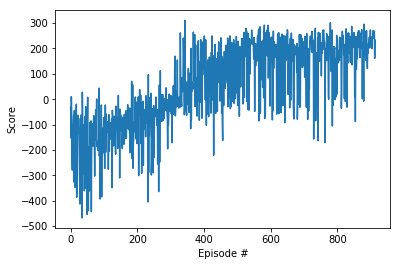

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [13]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(500):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()